In [20]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# import  sys
# sys.path.append('/content/gdrive/MyDrive/python_notebooks/grbas_capev/')

In [21]:
# import sys
# !pip uninstall kymatio
# !rm -r /content/kymatio.egg-info
# !rm -r /content/kymatio
# !git clone https://github.com/kymatio/kymatio.git
# sys.path.append('/content/kymatio')
# # !pip install -r kymatio/requirements.txt
# # !python kymatio/setup.py install

# # #!pip uninstall kymatio
# # sys.path.append('/content/gdrive/MyDrive/scatter_signal_typing')
# !pip install -e /content/kymatio

In [22]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pandas
from utils import * 
import pickle

In [23]:
file_path = ''
with open(file_path + 'results_hp.pkl', 'rb') as f:
    min_rmse_results = pickle.load(f)

# min_rmse_results['min_rmse'] = (mse[j,g],std_mse[j,g])
J = min_rmse_results['Jmin']
G = min_rmse_results['Gmin']
X_val = min_rmse_results['X_val_min']
y_val = min_rmse_results['y_val_min'] 
sev,rou,bre,srt,pit,lou = min_rmse_results['traits']


In [24]:
results = hp_fun(X_val, y_val,10, sev, rou, bre, srt, pit, lou)
(mean_mse,std_mse) = results['overall_rmse']
(mean_mout, std_mout) = results['all_outputs_rmse']
Rmats = results['correlation_matrices']
acums = results['acumulated_vectors']
mean_r2mout, std_r2mout = results['correlations_per_trait'] 
mean_r2mout, std_r2mout = results['correlations_per_trait'] 

print('Mean mse:{}'.format(mean_mse))
print('Stf mse:{}'.format(std_mse))
print('Mean mout:{}'.format(mean_mout))
print('Std mout:{}'.format(std_mout))
print('Mean corr out:{}'.format(mean_r2mout))
print('Std corr out:{}'.format(std_r2mout))

Mean mse:14.338220187123952
Stf mse:2.0016675577789833
Mean mout:[15.01467894 13.76365939 12.87546301 14.90981057 14.05387949 14.68818064]
Std mout:[2.94908858 2.48833282 2.69260254 1.92513781 2.23958891 3.23625692]
Mean corr out:[0.77367792 0.63956301 0.75308011 0.67099758 0.64402999 0.71296591]
Std corr out:[0.09007574 0.12096804 0.10391357 0.13454057 0.14597842 0.14405051]


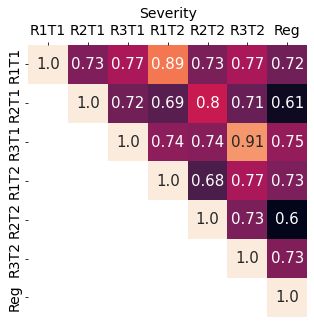

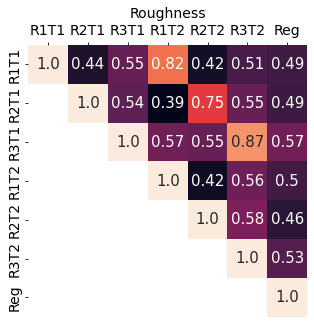

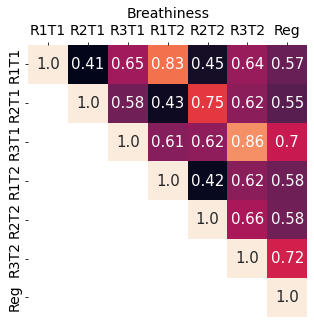

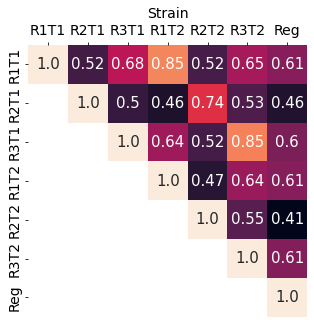

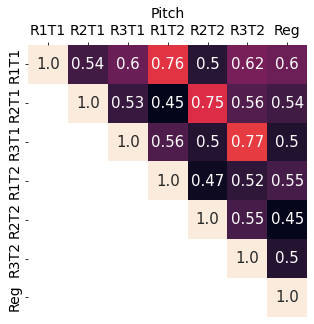

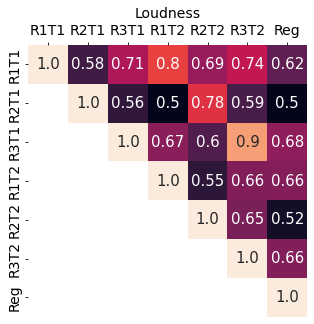

In [25]:
# Correlation matrices
corr_labels = ['R1T1','R2T1','R3T1','R1T2','R2T2','R3T2','Reg']
aspects_names = ['Severity', 'Roughness','Breathiness','Strain','Pitch','Loudness']

for i, r in enumerate(Rmats):
  fig = plt.figure()
  aux = np.mean(Rmats[r], axis = 0)
  # np.fill_diagonal(aux,1)
  dfr = pd.DataFrame(aux)
  dfr.columns = corr_labels
  dfr.index  = corr_labels
  mask = np.tril(np.mean(dfr, axis = 0))
  np.fill_diagonal(mask,0)
  corrtable = sns.heatmap(dfr, mask = mask, annot=True, cbar=False, annot_kws={"size": 15}, fmt = '.2')

  corrtable.xaxis.set_label_position('top') 
  corrtable.xaxis.tick_top()
  corrtable.set_xticklabels(corrtable.get_yticklabels(), horizontalalignment='center', fontsize = 14)
  corrtable.set_yticklabels(corrtable.get_yticklabels(), verticalalignment='center', fontsize = 14)
  plt.title(r, fontsize = 14)
  fig.set_size_inches((5,5))
  filename = 'figures/correlation_matrices/' + aspects_names[i]
  plt.savefig(filename + '.pdf',bbox_inches='tight')# , format='svg')

[20.00686423 19.33633465 17.89599377 19.76734696 20.25768175 18.29919068]
[1.15247477 4.64421887 2.60795975 1.00562256 4.6426777  2.27955597]


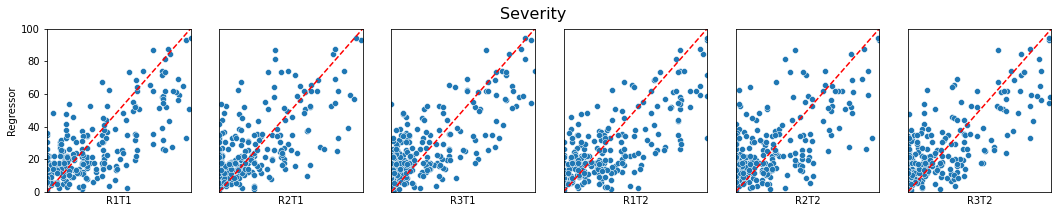

In [26]:
y_acum, y_acum_hat,idx_acum  = acums[0], acums[1], acums[2]
# print(y_acum_hat[:,0])

print(results['rmse_raters']['Severity'][0])
print(results['rmse_raters']['Severity'][1])

rater_index = ['R1T1','R2T1','R3T1','R1T2','R2T2','R3T2']
fig, axs = plt.subplots(1, 6, figsize = (18,3))#, gridspec_kw={'width_ratios': [3, 1, 1 ,1]})
fig.suptitle('Severity', fontsize=16)
for j in range(6):
    ax = axs[j]
    aux = sev[:,j]
    sns.scatterplot(x = aux, y = y_acum_hat[:,0], ax = ax)
    ax.plot([0,100],[0,100],'r--')
    ax.set_xticklabels([])
    ax.set_xticks([])
    if j != 0:
      ax.set_yticklabels([])
      ax.set_yticks([])
    if j == 0:
      ax.set_ylabel('Regressor')
    
    ax.set_xlabel(rater_index[j])
    ax.set_xlim([0,100])
    ax.set_ylim([0,100])

    
filename = 'figures/scatter_plots/scatter_plots_severity'
plt.savefig(filename + '.png',bbox_inches='tight')# , format='svg')
    


[20.32285212 18.42124385 17.30401996 20.54571393 19.86362592 18.04683581]
[2.33045337 3.691125   2.01730195 3.18677319 3.1298087  3.06940438]


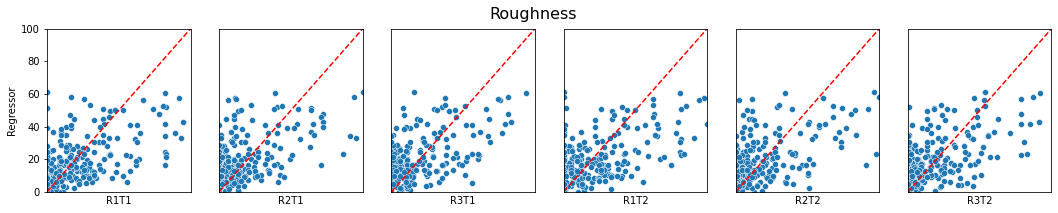

In [27]:
print(results['rmse_raters']['Roughness'][0])
print(results['rmse_raters']['Roughness'][1])

fig, axs = plt.subplots(1, 6, figsize = (18,3))#, gridspec_kw={'width_ratios': [3, 1, 1 ,1]})
fig.suptitle('Roughness', fontsize=16)
for j in range(6):
    ax = axs[j]
    aux = rou[:,j]
    sns.scatterplot(x = aux, y = y_acum_hat[:,1], ax = ax)
    ax.plot([0,100],[0,100],'r--')
    ax.set_xticklabels([])
    ax.set_xticks([])
    if j != 0:
      ax.set_yticklabels([])
      ax.set_yticks([])
    if j == 0:
      ax.set_ylabel('Regressor')
    
    ax.set_xlabel(rater_index[j])
    ax.set_xlim([0,100])
    ax.set_ylim([0,100])

filename = 'figures/scatter_plots/scatter_plots_roughness'
plt.savefig(filename + '.png',bbox_inches='tight')# , format='svg')

[21.00225667 18.35498644 16.90669551 20.7329814  18.42215008 16.4572765 ]
[3.86161563 4.34434506 3.25275225 2.59128582 4.36786157 3.17402358]


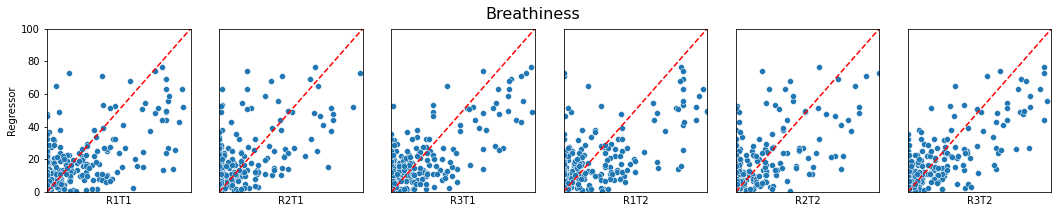

In [28]:
print(results['rmse_raters']['Breathiness'][0])
print(results['rmse_raters']['Breathiness'][1])

fig, axs = plt.subplots(1, 6, figsize = (18,3))#, gridspec_kw={'width_ratios': [3, 1, 1 ,1]})
fig.suptitle('Breathiness', fontsize=16)
for j in range(6):
    ax = axs[j]
    aux = bre[:,j]
    sns.scatterplot(x = aux, y = y_acum_hat[:,2], ax = ax)
    ax.plot([0,100],[0,100],'r--')
    ax.set_xticklabels([])
    ax.set_xticks([])
    if j != 0:
      ax.set_yticklabels([])
      ax.set_yticks([])
    if j == 0:
      ax.set_ylabel('Regressor')
    
    ax.set_xlabel(rater_index[j])
    ax.set_xlim([0,100])
    ax.set_ylim([0,100])

filename = 'figures/scatter_plots/scatter_plots_breathiness'
plt.savefig(filename + '.png',bbox_inches='tight')# , format='svg')

[21.14348933 20.11878657 18.72376489 21.30320863 22.11126637 18.56595195]
[2.65274834 2.62427247 2.43753132 2.37688982 3.52294503 3.09469843]


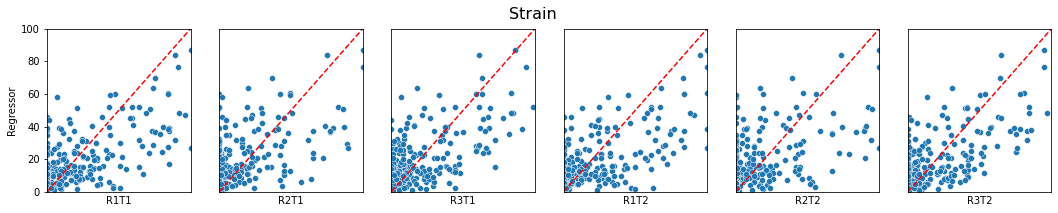

In [29]:
print(results['rmse_raters']['Strain'][0])
print(results['rmse_raters']['Strain'][1])

fig, axs = plt.subplots(1, 6, figsize = (18,3))#, gridspec_kw={'width_ratios': [3, 1, 1 ,1]})
fig.suptitle('Strain', fontsize=16)
for j in range(6):
    ax = axs[j]
    aux = srt[:,j]
    sns.scatterplot(x = aux, y = y_acum_hat[:,3], ax = ax)
    ax.plot([0,100],[0,100],'r--')
    ax.set_xticklabels([])
    ax.set_xticks([])
    if j != 0:
      ax.set_yticklabels([])
      ax.set_yticks([])
    if j == 0:
      ax.set_ylabel('Regressor')
    
    ax.set_xlabel(rater_index[j])
    ax.set_xlim([0,100])
    ax.set_ylim([0,100])
filename = 'figures/scatter_plots/scatter_plots_strain'
plt.savefig(filename + '.png',bbox_inches='tight')# , format='svg')

[17.77644032 18.92301889 18.26990402 18.99381663 21.32881918 19.55375778]
[2.11690153 4.47018426 3.87766455 3.25845924 4.42593452 3.42412972]


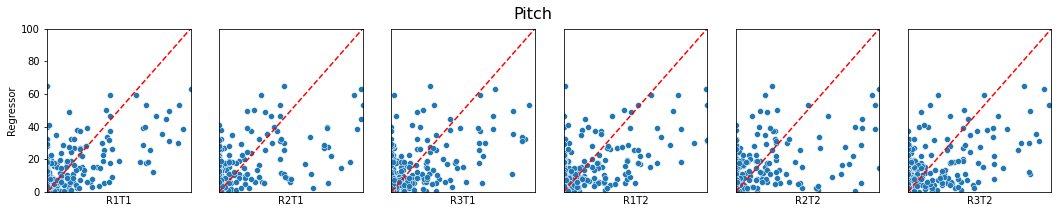

In [30]:
print(results['rmse_raters']['Pitch'][0])
print(results['rmse_raters']['Pitch'][1])

fig, axs = plt.subplots(1, 6, figsize = (18,3))#, gridspec_kw={'width_ratios': [3, 1, 1 ,1]})
fig.suptitle('Pitch', fontsize=16)
for j in range(6):
    ax = axs[j]
    aux = pit[:,j]
    sns.scatterplot(x = aux, y = y_acum_hat[:,4], ax = ax)
    ax.plot([0,100],[0,100],'r--')
    ax.set_xticklabels([])
    ax.set_xticks([])
    if j != 0:
      ax.set_yticklabels([])
      ax.set_yticks([])
    if j == 0:
      ax.set_ylabel('Regressor')
    
    ax.set_xlabel(rater_index[j])
    ax.set_xlim([0,100])
    ax.set_ylim([0,100])

filename = 'figures/scatter_plots/scatter_plots_pitch'
plt.savefig(filename + '.png',bbox_inches='tight')# , format='svg')

[17.77644032 18.92301889 18.26990402 18.99381663 21.32881918 19.55375778]
[2.11690153 4.47018426 3.87766455 3.25845924 4.42593452 3.42412972]


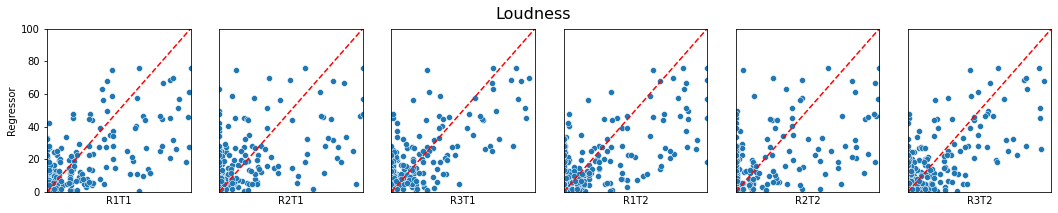

In [31]:
print(results['rmse_raters']['Pitch'][0])
print(results['rmse_raters']['Pitch'][1])

fig, axs = plt.subplots(1, 6, figsize = (18,3))#, gridspec_kw={'width_ratios': [3, 1, 1 ,1]})
fig.suptitle('Loudness', fontsize=16)
for j in range(6):
    ax = axs[j]
    aux = lou[:,j]
    sns.scatterplot(x = aux, y = y_acum_hat[:,5], ax = ax)
    ax.plot([0,100],[0,100],'r--')
    ax.set_xticklabels([])
    ax.set_xticks([])
    if j != 0:
      ax.set_yticklabels([])
      ax.set_yticks([])
    if j == 0:
      ax.set_ylabel('Regressor')
    
    ax.set_xlabel(rater_index[j])
    ax.set_xlim([0,100])
    ax.set_ylim([0,100])

filename = 'figures/scatter_plots/scatter_plots_loudness'
plt.savefig(filename + '.png',bbox_inches='tight')# , format='svg')

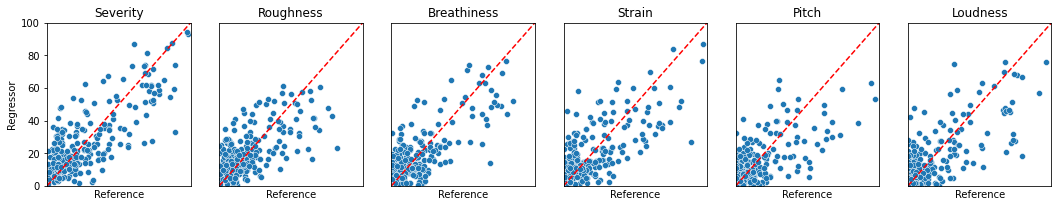

In [32]:
fig, axs = plt.subplots(1, 6, figsize = (18,3))#, gridspec_kw={'width_ratios': [3, 1, 1 ,1]})
# fig.suptitle('Ground Truth', fontsize=16)
trait_index = ['Severity', 'Roughness', 'Breathiness', 'Strain', 'Pitch','Loudness']
for j in range(6):
    ax = axs[j]
    aux = y_acum[:,j]
    sns.scatterplot(x = aux, y = y_acum_hat[:,j], ax = ax)
    ax.plot([0,100],[0,100],'r--')
    ax.set_xticklabels([])
    ax.set_xticks([])
    if j != 0:
      ax.set_yticklabels([])
      ax.set_yticks([])
    if j == 0:
      ax.set_ylabel('Regressor')
    
    ax.set_title(trait_index[j])
    ax.set_xlabel('Reference')
    ax.set_xlim([0,100])
    ax.set_ylim([0,100])

filename = 'figures/scatter_plots/scatter_plots_averages'
plt.savefig(filename + '.png',bbox_inches='tight')# , format='svg')